# LPPUFv1 Reliability Analysis

In [1]:
import numpy as np
import pypuf.batch
import pypuf.metrics

from lppuf import LPPUFv1

In [2]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [3]:
%%bash
mkdir -p results/v1/reliability

In [4]:
results = pypuf.batch.FilesystemResultCollection('results/v1/reliabilty')

In [5]:
class LPPUFv1ReliabilityAnalysis(pypuf.batch.StudyBase):
    
    def parameter_matrix(self):
        return [
            dict(
                n=n,
                noisiness_1=noisiness_1,
                noisiness_2=noisiness_2,
                seed=seed,
                m=m,
            )
            for n in [64]
            for noisiness_1 in [.01,.02,.05,.1, .2, .35, .5]
            for noisiness_2 in [.01,.02,.05,.1, .2, .35, .5]
            for seed in range(10)
            for m in [2, 4, 8, 16]
        ]
    
    def run(self, n, noisiness_1, noisiness_2, seed, m):
        puf = LPPUFv1(n=n, m=m, noisiness_1=noisiness_1, noisiness_2=noisiness_2, seed=seed)
        r = 5
        N = 1000
        return {
            'r': np.mean(pypuf.metrics.reliability(puf, seed=1, r=r, N=N)),
            'r1': np.mean(pypuf.metrics.reliability(puf.layer[0], seed=1, r=r, N=N)),
            'r2': np.mean(pypuf.metrics.reliability(puf.layer[2], seed=1, r=r, N=N)),
        } 

In [6]:
study = LPPUFv1ReliabilityAnalysis(results)

In [7]:
study.run_all()

DEBUG:root:LPPUFv1ReliabilityAnalysis: running 0 unfinished jobs from a batch of 1960 (1960 of this batch already completed, batch total 1960, study total 1960 jobs)


In [8]:
import pandas as pd

In [9]:
data = pd.DataFrame(results.load_all())

In [10]:
data = data[
    ~data['noisiness_1'].isin([.005, .5]) &
    ~data['noisiness_2'].isin([.005, .5])
]

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
%%bash
mkdir -p figures

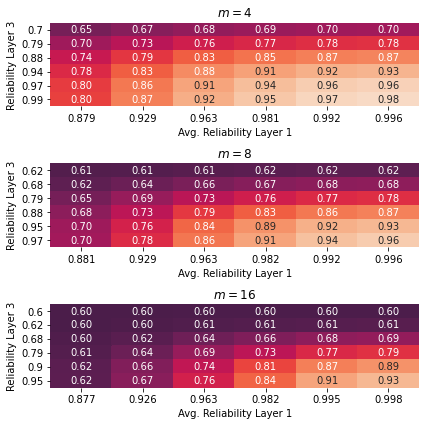

In [26]:
ms = [4, 8, 16]

f, axes = plt.subplots(nrows=len(ms), ncols=1, figsize=(len(ms) * 2, 6))

for m, ax in zip(ms, axes.flatten()):
    data1 = data[data['m']==m].copy()
    data1 = data1.groupby(['noisiness_1', 'noisiness_2']).mean().round(3)
    data1['r2'] = data1['r2'].round(2)
    data1['Avg. Reliability Layer 1'] = data1['r1']
    data1['Reliability Layer 3'] = data1['r2']
    try:
        data1 = data1.pivot('Reliability Layer 3', 'Avg. Reliability Layer 1', 'r')
    except ValueError:
        logging.warning(f"Could not plot for m={m}")
        continue
    sns.heatmap(data1, annot=True, vmin=.5, vmax=1, ax=ax, fmt='.2f', cbar=False)
    ax.set_title(f'$m = {m}$')
    #plt.title(f"$m={m}$")
f.tight_layout(pad=1)
f.savefig(f'figures/lppufv1-reliability.pdf')